In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
raw_data = fetch_california_housing()
data = raw_data.data 

np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]
print(X_train.shape)
print(X_test.shape)

(14448, 8)
(6192, 8)


In [3]:
# Preprocessing 
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z 

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 3
LATENT_DIM = 2
BATCH_SIZE = 128
N_EPOCHS = 100
lr = 1e-3

In [6]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [7]:
avg_mu_x = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + torch.exp(std_z) * eps
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x.shape

avg_mu_x = avg_mu_x.detach().numpy()

In [8]:
avg_mu_x

array([[ 0.43542472, -0.0331989 , -0.01829819, ...,  0.2013285 ,
         0.31314546,  0.46364367],
       [ 0.41644597, -0.04960801, -0.02836859, ...,  0.19592047,
         0.3115943 ,  0.45723617],
       [ 0.41520694, -0.05067936, -0.02902608, ...,  0.19556741,
         0.311493  ,  0.45681772],
       ...,
       [ 0.4146798 , -0.05113516, -0.02930581, ...,  0.19541715,
         0.31144994,  0.45663965],
       [ 0.41506016, -0.05080637, -0.02910402, ...,  0.19552553,
         0.31148103,  0.45676816],
       [ 0.41391084, -0.05179996, -0.02971381, ...,  0.19519807,
         0.31138703,  0.45638016]], dtype=float32)

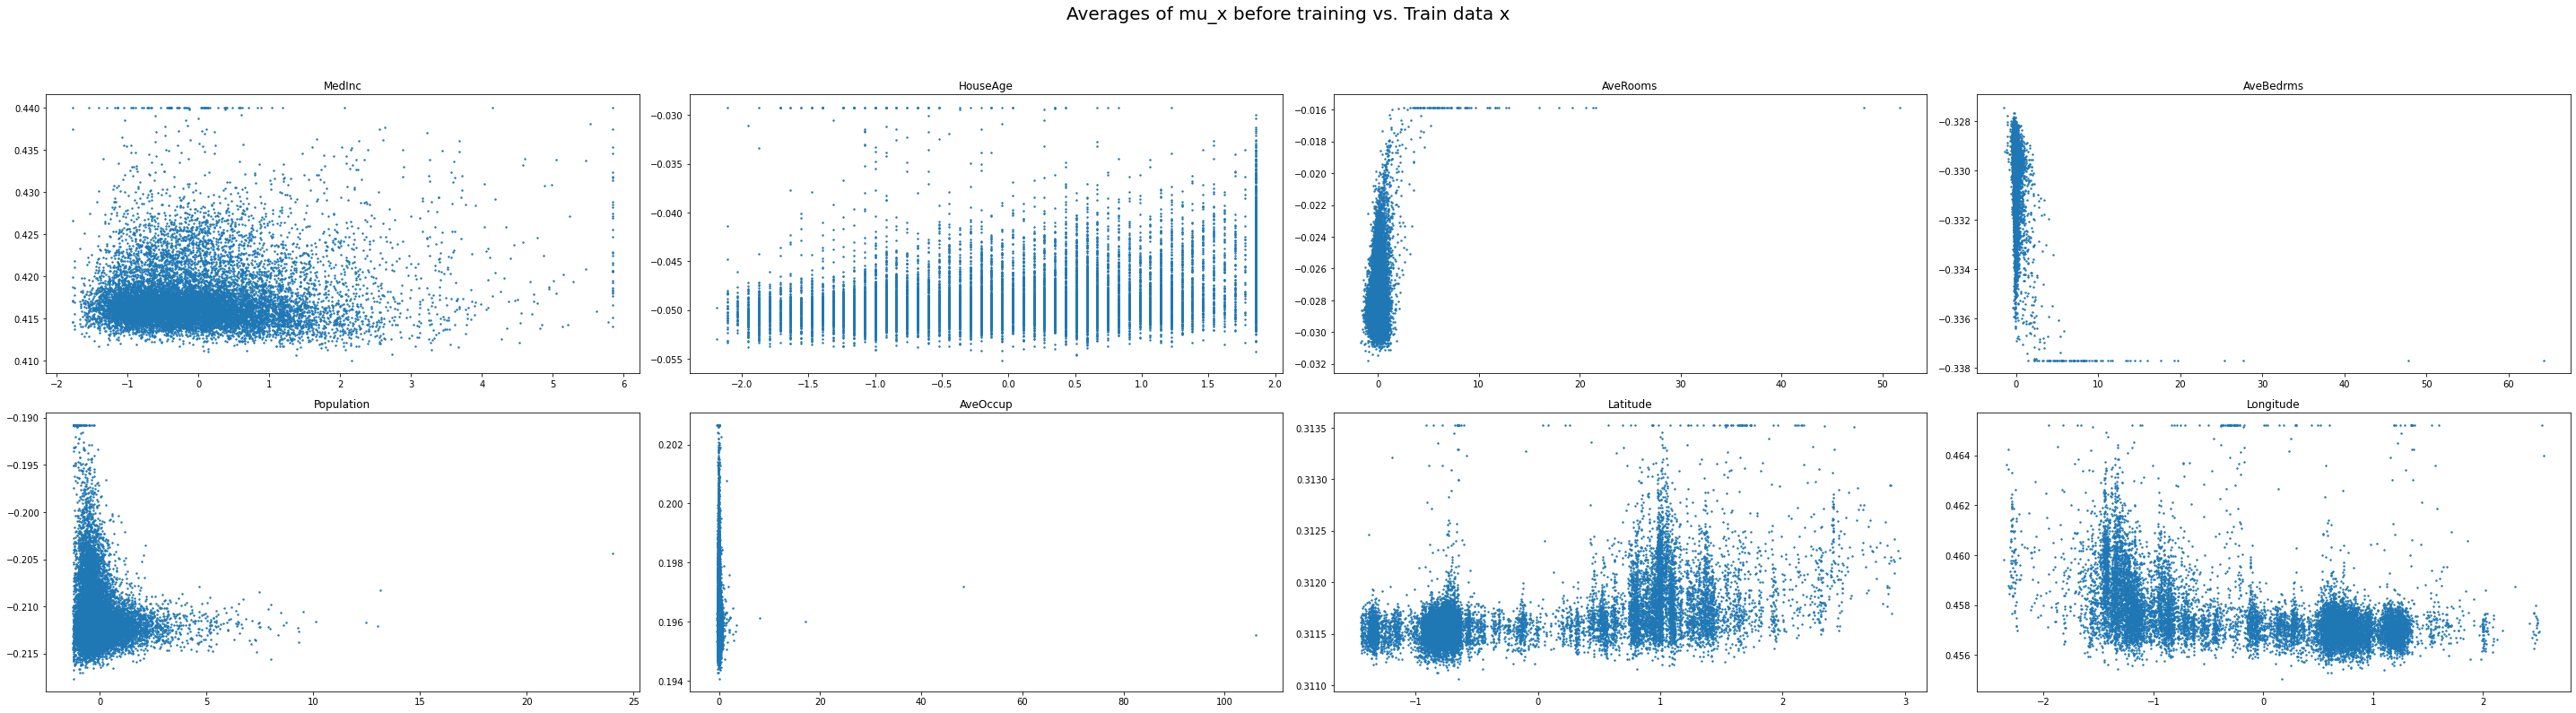

In [9]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
for i in range(2): 
    for j in range(4): 
        axs[i, j].scatter(X_train[:, i*4+j], avg_mu_x[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])

figs.tight_layout()
plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=20, y=1.1)
plt.show()

In [10]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [11]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [12]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)
test_iter = DataLoader(X_test, batch_size=BATCH_SIZE)

In [13]:
train_loss_avg = []
test_loss_avg = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x in train_iter: 
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        mu_x, std_x = dec(z_samples)
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
#     scheduler.step()
    train_loss_avg[-1] /= num_batches
    
    test_loss_avg.append(0)
    num_batches = 0
    for x_test in test_iter:
        # test
        mu_z_test, std_z_test = enc(x_test)
        eps_test = torch.randn_like(std_z_test)
        z_samples_test = mu_z_test + eps_test * torch.exp(std_z_test)

        mu_x_test, std_x_test = dec(z_samples_test)

        # loss 
        test_loss = loss_fn(mu_z_test, std_z_test, z_samples_test, mu_x_test, std_x_test, x_test)
        test_loss_avg[-1] += test_loss.item()
        num_batches += 1
    test_loss_avg[-1] /= num_batches
    
    print("Epoch [%d / %d] train loss: %f, test loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1], test_loss_avg[-1]))

Epoch [1 / 100] train loss: 12.542664, test loss: 28.833438
Epoch [2 / 100] train loss: 11.892327, test loss: 25.379085
Epoch [3 / 100] train loss: 11.583577, test loss: 23.478588
Epoch [4 / 100] train loss: 11.105909, test loss: 22.537161
Epoch [5 / 100] train loss: 10.836617, test loss: 21.708019
Epoch [6 / 100] train loss: 10.338597, test loss: 20.749378
Epoch [7 / 100] train loss: 10.040737, test loss: 20.418461
Epoch [8 / 100] train loss: 9.867516, test loss: 19.857998
Epoch [9 / 100] train loss: 9.638469, test loss: 19.022052
Epoch [10 / 100] train loss: 9.493715, test loss: 18.731099
Epoch [11 / 100] train loss: 9.311605, test loss: 18.363446
Epoch [12 / 100] train loss: 9.168105, test loss: 17.580330
Epoch [13 / 100] train loss: 9.181650, test loss: 17.170415
Epoch [14 / 100] train loss: 8.958270, test loss: 16.771731
Epoch [15 / 100] train loss: 8.898088, test loss: 16.537855
Epoch [16 / 100] train loss: 8.753581, test loss: 15.978266
Epoch [17 / 100] train loss: 8.664243, tes

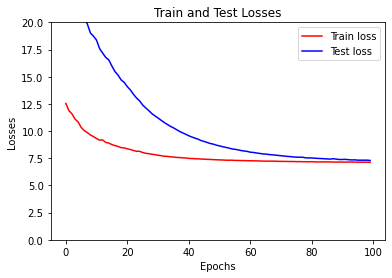

In [14]:
plt.plot(train_loss_avg, "r")
plt.plot(test_loss_avg, "b")
plt.legend(["Train loss", "Test loss"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.ylim(0, 20)
plt.title("Train and Test Losses")
plt.show()

In [15]:
avg_mu_x_trained = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_trained += mu_x

avg_mu_x_trained /= 100
avg_mu_x_trained = avg_mu_x_trained.detach().numpy()

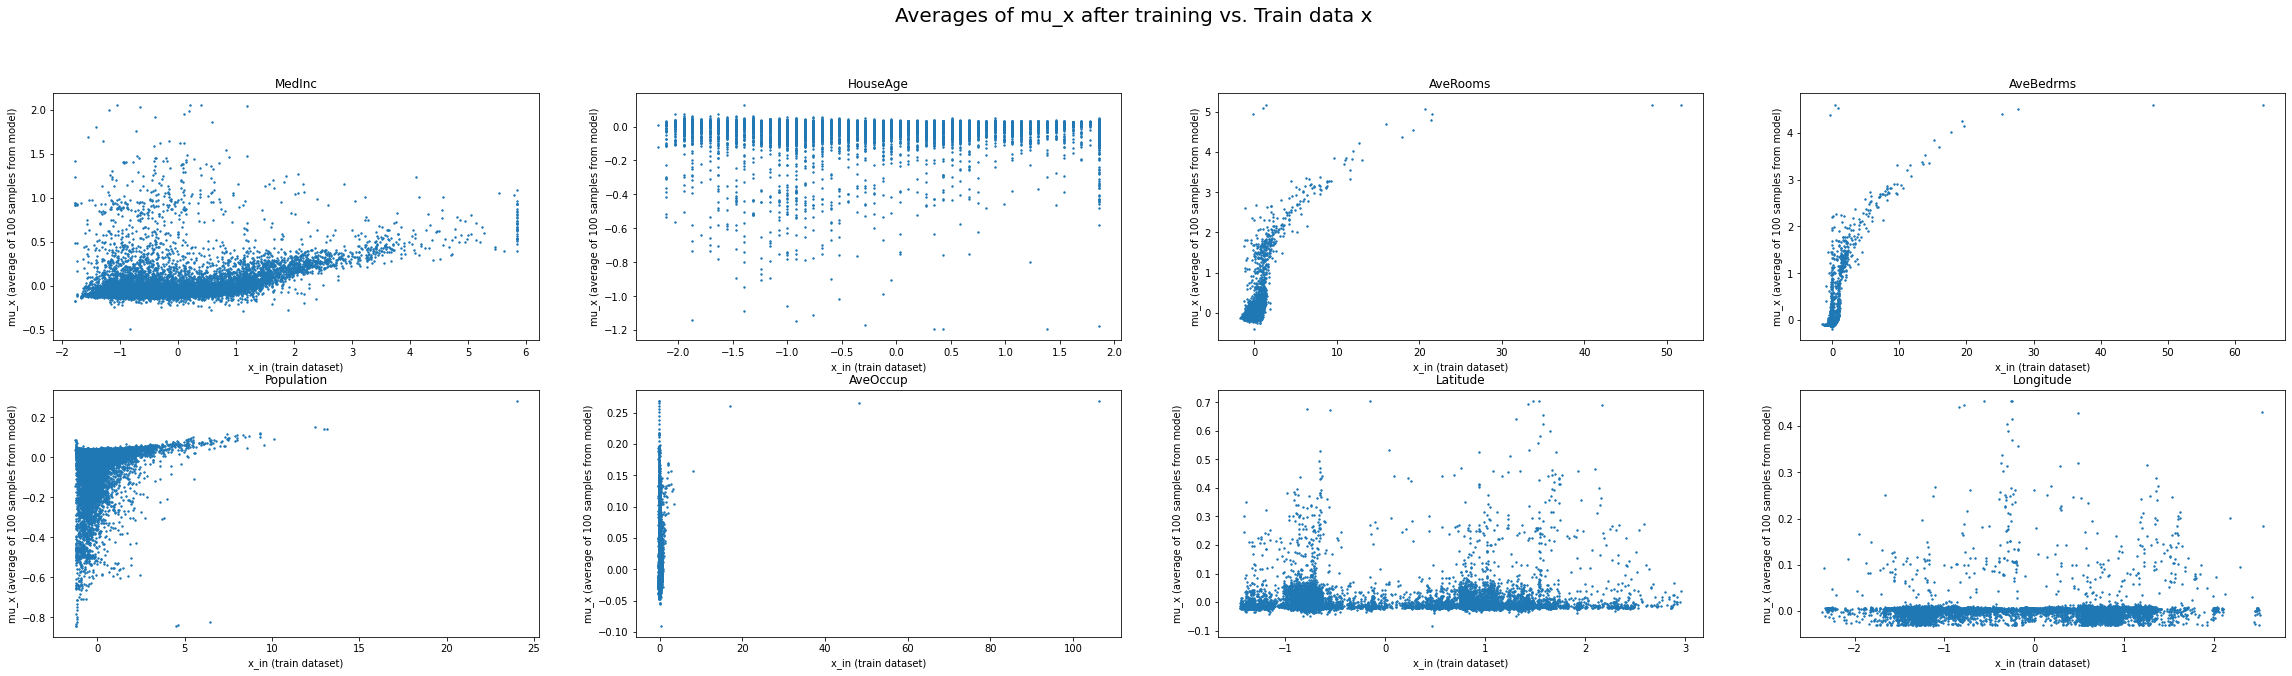

In [16]:
# avg_mu_x_trained = avg_mu_x_trained.detach().numpy()
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
count = 0 
for i in range(2):
    for j in range(4):
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x_trained[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=20, y=1)
plt.show()

In [17]:
import matplotlib.colors as mcolors
import seaborn as sns

levs = range(12)
assert len(levs) % 2 == 0, 'N levels must be even.'

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0), 
                                                          (1, 1., 1), 
                                                          (0, 0, 1)],
                                                 N=len(levs)-1)

In [18]:
p_z = torch.distributions.Normal(0, 1)
z = p_z.sample((1000, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

torch.Size([1000, 8])


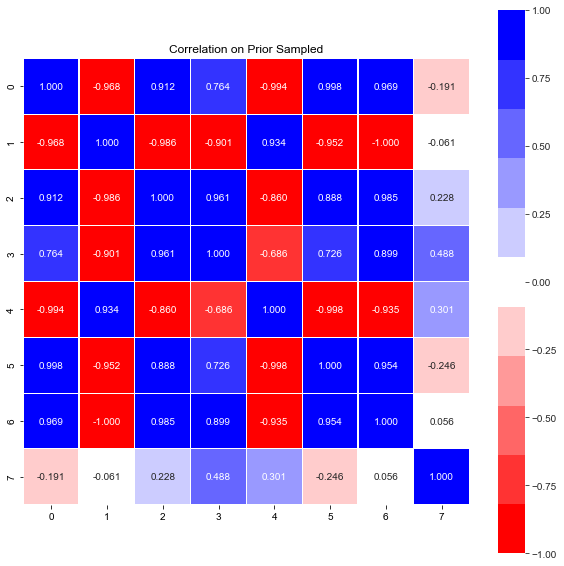

In [19]:
mu_x = mu_x.detach().numpy()
corr_eval = np.corrcoef(mu_x, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_eval, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Prior Sampled")
    plt.show()

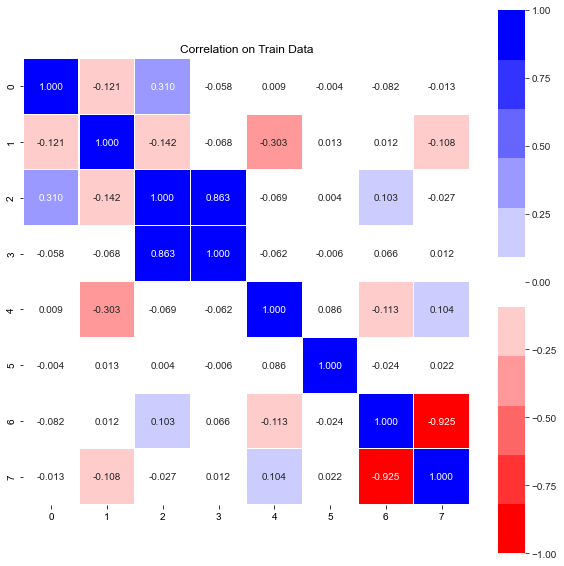

In [20]:
corr_train = np.corrcoef(X_train, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_train, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Train Data")
    plt.show()

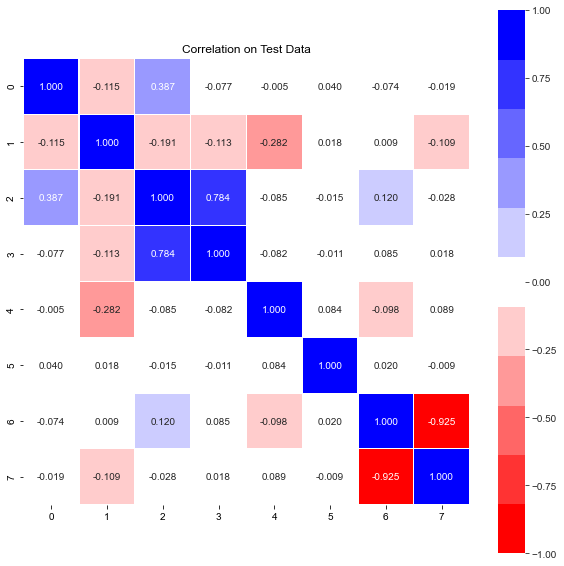

In [21]:
corr_test = np.corrcoef(X_test, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))  
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Test Data")
    plt.show()